In [30]:
#import sys
#!{sys.executable} -m pip install emcee
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


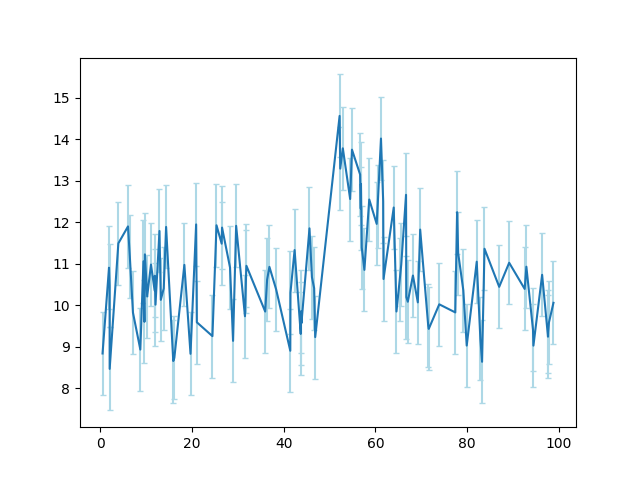

<ErrorbarContainer object of 3 artists>

In [41]:
file = np.load("../solutions/transient.npy", "r")
#print(file[:, 0])
#plt.plot(file[:, 0], file[:, 1])
plt.errorbar(file[:, 0], file[:, 1], yerr = file[:,2] , xerr=None, ecolor='lightblue', capsize = 2, capthick = 1)


One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.


In [55]:
def model_ (t, t0, b, A, alpha):
    if (t < t0):
        return b
    else:
        return b + A * np.exp(- alpha * (t-t0))

[1.         1.         1.41520619 1.36394424 1.35993215 1.05399957
 1.00658773 1.00445045 1.00223479 1.00044701 1.00022621 1.0001823
 1.00016491 1.00010059 1.00004373 1.00001985 1.00001897 1.00001638
 1.00000684 1.00000513 1.00000271 1.00000162 1.00000034 1.00000027
 1.00000003 1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.

<IPython.core.display.Javascript object>


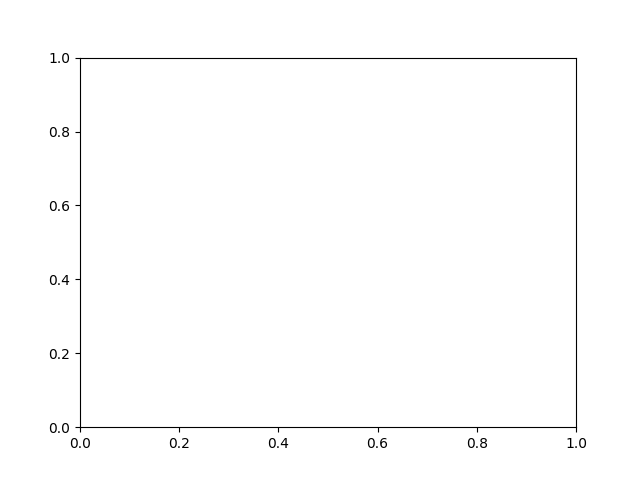

ValueError: x and y must have same first dimension, but have shapes (201,) and (100,)

In [59]:
t0 = 1
b = 1
A = 1
alpha = 1

for t in (file[:, 0]):
    model = np.append(model, model_(t, t0, b, A, alpha))
    
#print(model)

plt.plot(model, file[:,0])

we have to write down a likelihood:

gaussian likelihood ---> since central limit theorem etc.

product of probabilities: proportional of the exp

L(


In [ ]:
Likelihood = 